In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
import core
import keras
import tensorflow as tf
import os


PLOTS_DIR = f"plots/toponium_transformer_high_level_features/"
MODEL_DIR = f"models/toponium_transformer_high_level_features/"
CONFIG_PATH = "../config/workspace_config_high_level_features.yaml"

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)


load_config = get_load_config_from_yaml(CONFIG_PATH)

DataProcessor = DataPreprocessor(load_config)


with open(CONFIG_PATH, "r") as file:
    data_configs = yaml.safe_load(file)
plt.rcParams.update({"font.size": 14})

data_config = DataProcessor.load_from_npz(
    data_configs["npz_datapath"]["toponium"], max_events=1000000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)
del DataProcessor

2025-11-20 11:09:22.034287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763633362.059347 2815735 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763633362.067522 2815735 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763633362.086723 2815735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763633362.086752 2815735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763633362.086755 2815735 computation_placer.cc:177] computation placer alr

In [2]:
data_config.get_feature_index("non_training","truth_ttbar_mass")

2

In [3]:
reload(Models)
reload(core)
TransformerMatcher = Models.FeatureConcatTransformer(data_config, name="ToponiumTransformer")

#TransformerMatcher.load_model(MODEL_DIR + "model.keras")
TransformerMatcher.build_model(
    hidden_dim=64,
    num_layers=6,
    num_heads=8,
    dropout_rate=0.1
)

TransformerMatcher.adapt_normalization_layers(X_train)

TransformerMatcher.compile_model(
    loss={
        "assignment": core.utils.AssignmentLoss(lambda_excl=0.0),
    },
    optimizer=keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    metrics={
        "assignment": [core.utils.AssignmentAccuracy()],
    },
)

FeatureConcatTransformer is designed for classification tasks; regression targets will be ignored.


I0000 00:00:1763633392.570389 2815735 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:65:00.0, compute capability: 6.0


Building model without regression output.


In [4]:
TransformerMatcher.train_model(
    epochs=0,
    X_train=X_train,
    y_train=y_train,
    sample_weights=core.utils.compute_sample_weights(X_train, y_train),
    batch_size=1024,
)

Epoch 1/100


I0000 00:00:1763633413.128707 2816347 service.cc:152] XLA service 0x7f0aac00f790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763633413.128732 2816347 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-20 11:10:13.837972: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-20 11:10:14.613684: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
I0000 00:00:1763633416.640635 2816347 cuda_dnn.cc:529] Loaded cuDNN version 91500


  8/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.1811 - loss: 0.0015 

I0000 00:00:1763633431.419576 2816347 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


698/702 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2096 - loss: 0.0011

2025-11-20 11:10:43.294340: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


702/702 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2099 - loss: 0.0011

2025-11-20 11:11:00.777736: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-20 11:11:02.943594: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


702/702 ━━━━━━━━━━━━━━━━━━━━ 67s 47ms/step - accuracy: 0.2100 - loss: 0.0011 - val_accuracy: 0.4383 - val_loss: 7.9521e-04
Epoch 2/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4025 - loss: 8.5132e-04 - val_accuracy: 0.5219 - val_loss: 7.2204e-04
Epoch 3/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.4787 - loss: 7.8249e-04 - val_accuracy: 0.5608 - val_loss: 6.8572e-04
Epoch 4/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5195 - loss: 7.3967e-04 - val_accuracy: 0.5836 - val_loss: 6.5204e-04
Epoch 5/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5456 - loss: 7.0768e-04 - val_accuracy: 0.6230 - val_loss: 6.3084e-04
Epoch 6/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5680 - loss: 6.8399e-04 - val_accuracy: 0.6256 - val_loss: 6.1307e-04
Epoch 7/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5855 - loss: 6.6554e-04 - val_accuracy: 0.6473 - val_loss: 6.0428e-04
Epoch 8/100
702/702 ━━━━━━━━━━━━━━━━━━━━ 11

In [5]:
TransformerMatcher.save_model(MODEL_DIR + "model.keras")

Model saved to models/toponium_transformer_high_level_features/model.keras


In [6]:
import core.assignment_models.BaselineAssignmentMethods as BaselineMethods
import core.reconstruction as Evaluation

reload(Evaluation)
reload(BaselineMethods)
delta_r_assigner = BaselineMethods.DeltaRAssigner(
    data_config,
    use_nu_flows=True,
)
chi_square_true_nu = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=False,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)
chi_square = BaselineMethods.ChiSquareAssigner(
    data_config,
    use_nu_flows=True,
    use_nu_flows_for_assignment=True,
    top_mass=173.5e3,
)


ground_truth_assigner = Evaluation.GroundTruthReconstructor(
    data_config, name="True Assignment"
)
evaluator = Evaluation.ReconstructionEvaluator(
    [
        ground_truth_assigner,
        # delta_r_assigner,
        chi_square_true_nu,
        chi_square,
        TransformerMatcher,
    ],
    X_val,
    y_val,
)

2025-11-20 11:29:41.902448: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-20 11:29:45.878995: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert



Computing bootstrap confidence intervals...
True Assignment: Ground Truth (skipping)
$\chi^2$-Method ($\nu^2$-Flows): 0.4594 [0.4562, 0.4622]
$\chi^2$-Method ($\nu^2$-Flows): 0.4595 [0.4564, 0.4625]
ToponiumTransformer: 0.7831 [0.7806, 0.7855]


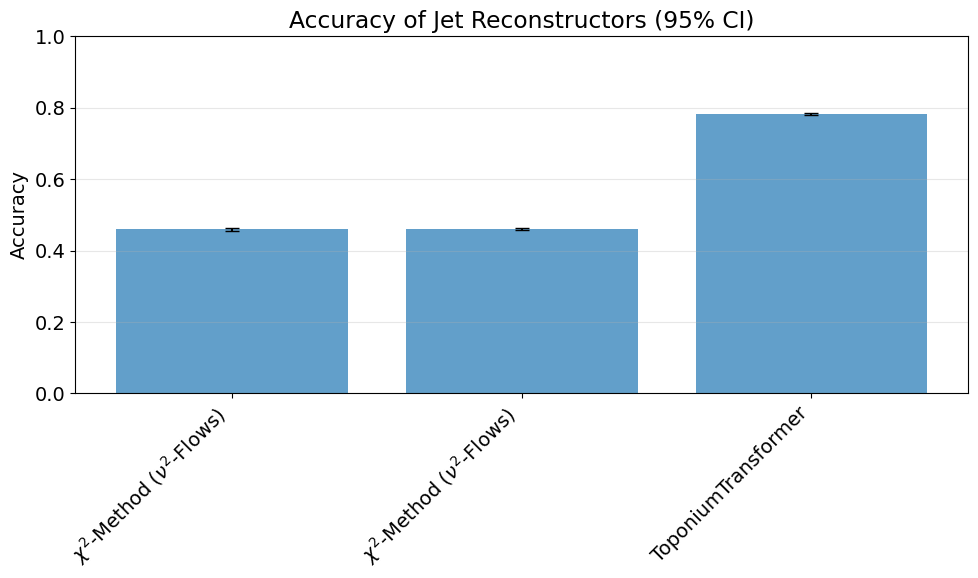

In [7]:
fig, ax = evaluator.plot_all_accuracies()
fig.savefig(PLOTS_DIR + "all_accuracies.pdf")


Computing binned top mass resolution for truth_ttbar_mass...


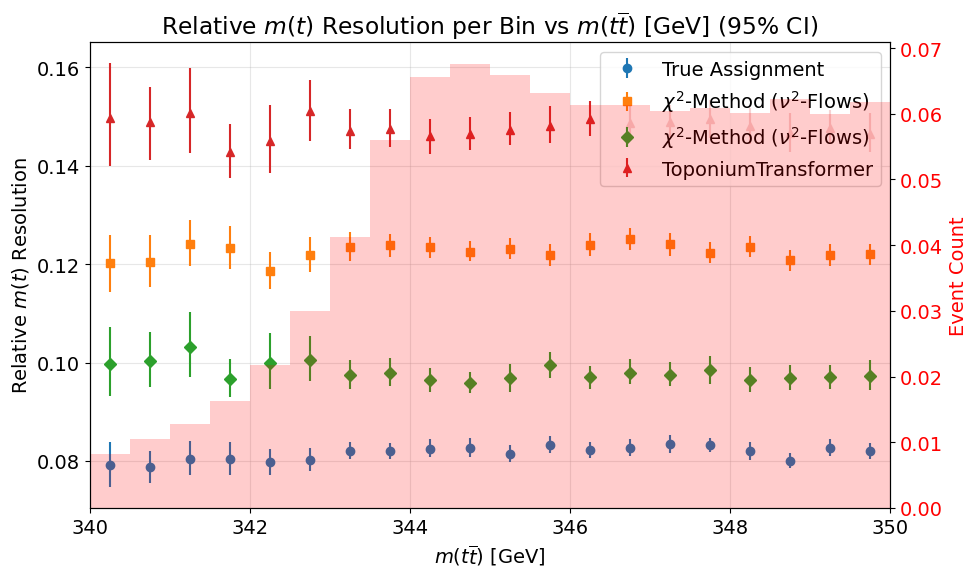

In [8]:
fig, ax = evaluator.plot_binned_top_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    xlims=[340e3, 350e3],
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
ax.set_xlim(340e3, 350e3)
fig.savefig(PLOTS_DIR + "top_mass_resolution_comparison.pdf")


Computing binned ttbar mass resolution for truth_ttbar_mass...


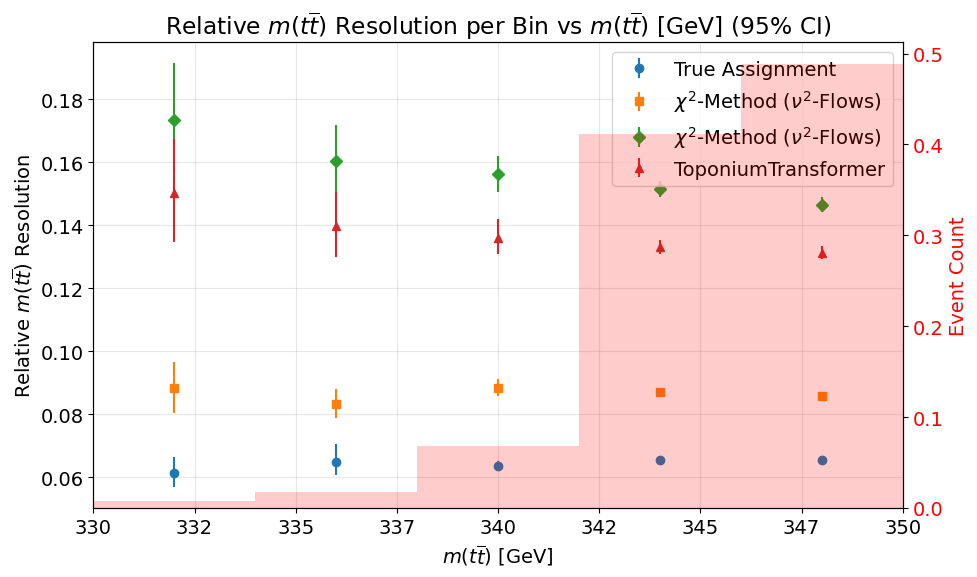

In [9]:
fig, ax = evaluator.plot_binned_ttbar_mass_resolution(
    feature_data_type="non_training",
    feature_name="truth_ttbar_mass",
    fancy_feature_label=r"$m(t\overline{t})$ [GeV]",
    bins=5,
    xlims=(330e3, 350e3)
)
ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f"{int(tick/1e3)}" for tick in ticks])
fig.savefig(PLOTS_DIR + "ttbar_mass_resolution_comparison.pdf")


Computing binned accuracy for N_jets...


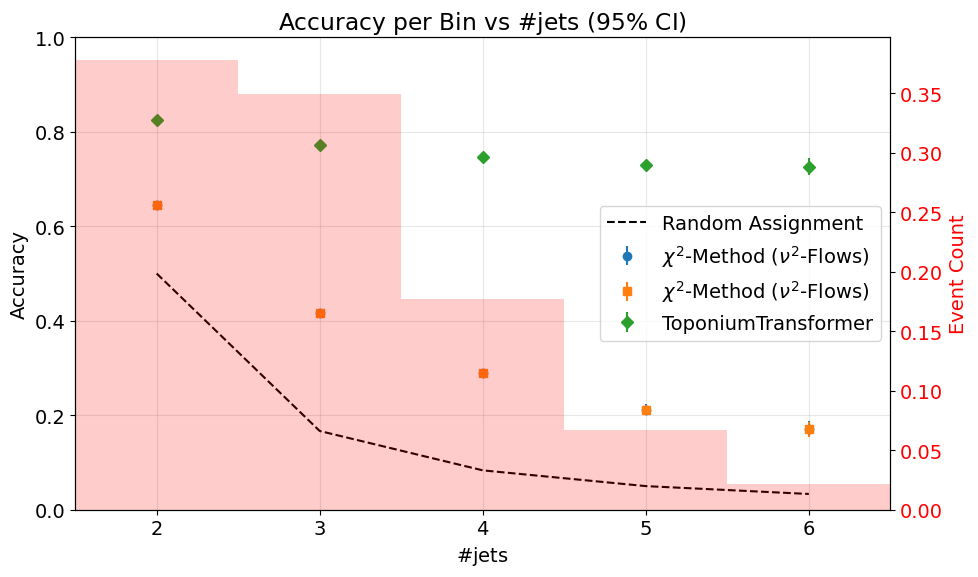

In [10]:
fig, ax = evaluator.plot_binned_accuracy(
    feature_data_type="non_training",
    feature_name="N_jets",
    fancy_feature_label=r"$\# \text{jets}$",
    xlims=(2, data_configs["LoadConfig"]["max_jets"] + 1),
    bins=data_configs["LoadConfig"]["max_jets"] - 1,
)
ax.set_xticks([i + 0.5 for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
ax.set_xticklabels([i for i in range(2, data_configs["LoadConfig"]["max_jets"] + 1)])
fig.savefig(PLOTS_DIR + "binned_accuracy_N_jets.pdf")

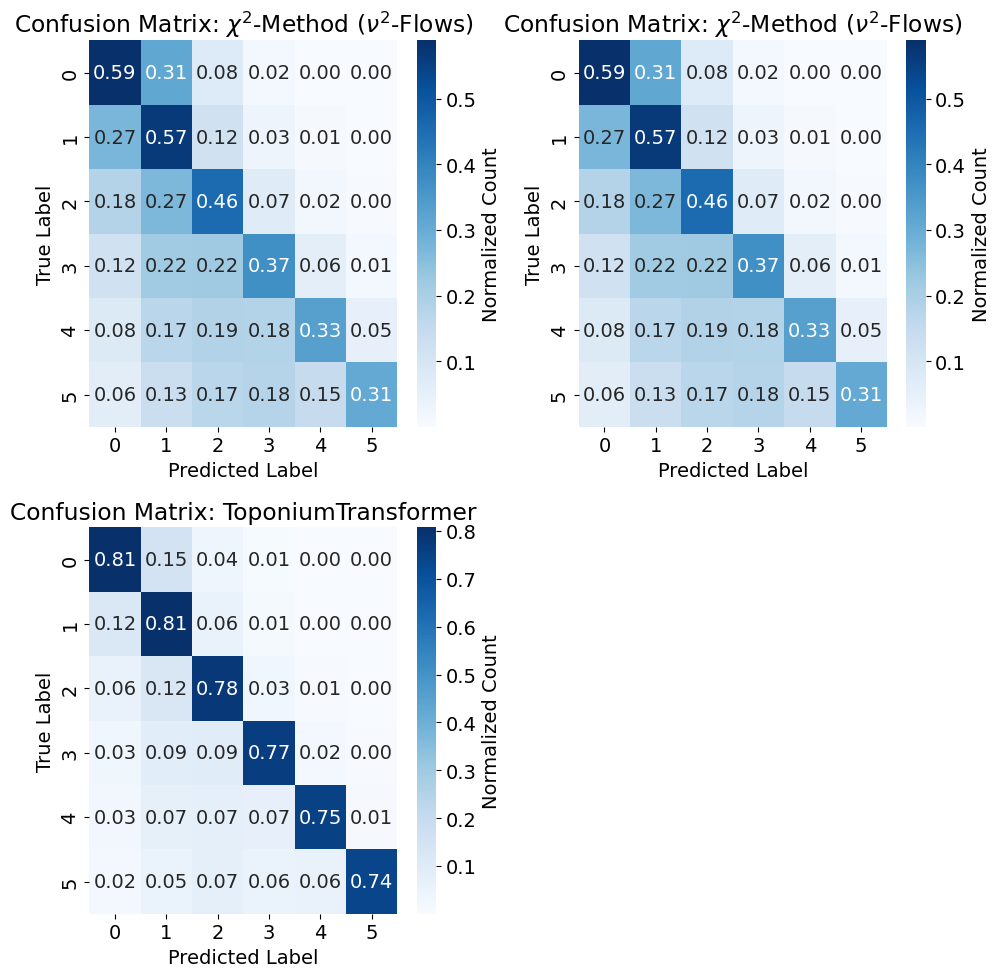

In [11]:
fig, ax = evaluator.plot_confusion_matrices()
fig.savefig(PLOTS_DIR + "confusion_matrices.pdf")

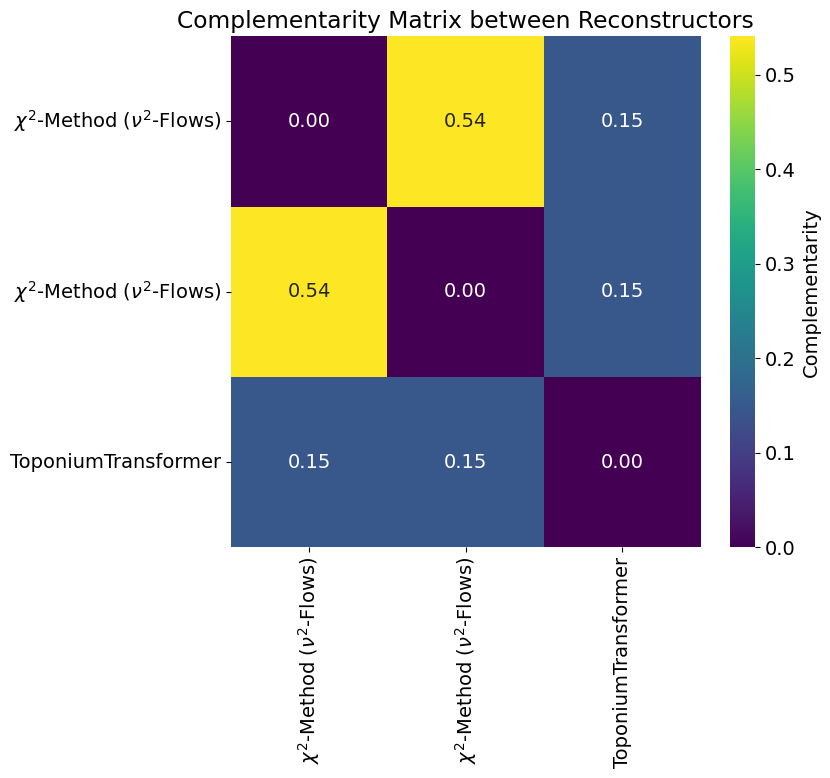

In [12]:
fig, ax = evaluator.plot_complementarity_matrix(figsize=(8.5, 8))
fig.savefig(PLOTS_DIR + "complementarity_matrix.pdf")